#### Importing necessary libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from scipy.io import wavfile
import python_speech_features
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from livelossplot import PlotLossesKeras
import sounddevice as sd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import butter, sosfilt
from timeit import default_timer as timer
from IPython.display import clear_output

#### Enabling config proto to make GPU working

But if you working this on Google Colab and your GPU is just fine, you do not have to run this

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#### Preprocessing

##### Create classes that we want to use (I'm not using all class in the terms of increasing accuracy)

If you have better dataset than mine that only had about 300 audio recordings at each class, you don't have to hesitate to use only half of them. Use them all.

I got the dataset from https://zenodo.org/record/4662481#.YkVMqZlBxEY made by Abdul Kadir Ghandoura which have these characteristic :
1. 16000 Hz Sampling Rate
2. Has 40 class (folder) x 30 people x 10 utterance = 12000 data
3. Duration of every audio is 1 sec
4. The modulation format is PCM signed 16-bit little-endian
5. Bitrate 256kbps
6. Mono channel


In [5]:
#arabic
word2index = {
    # core words
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "open": 10,
    "close": 11,
    "digit": 12,
    "start": 13,
    "stop": 14,
    "yes": 15,
    "no": 16,
    "up": 17,
    "down": 18,
    "move": 19,
}

index2word = [word for word in word2index]

Appending sample (the audio) and its label to a variable so in the next step we can calculate their MFCC.

In [6]:
num_classes = len(word2index)
num_samples_per_class = 300
speech_commands_dataset_basepath = Path(r"D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic Speech Recognition\data\dataset")
# speech_commands_dataset_basepath = Path(r"D:\AtlantisSeeker-UIN\Skripsi Imam\Sandbox\Shawn Hymel\tflite-speech-recognition-master\dataset")
print("loading dataset...")
samples = []
classes =  []
with tqdm(total=num_samples_per_class*20) as pbar:
    for word_class in word2index:
        folder = speech_commands_dataset_basepath / word_class # sub-folder for each word
        count = 0
        for file in folder.iterdir(): # iterate over all files in the folder
            # somehow, there are samples which aren't exactly 1 s long in the dataset. ignore those
            if file.stat().st_size == 32044:
                samples.append(file) # store path of sample file
                classes.append(word2index[word_class]) # append word class index to list
                count +=1
                pbar.update()
            if count >= num_samples_per_class:
                break
classes = np.array(classes, dtype=np.int)

loading dataset...


100%|██████████| 6000/6000 [00:00<00:00, 42453.62it/s]


Next, we create a function to calculate MFCC features using library python_peech_features. We create 2 function that actually is the same thing to do the calculation of the MFCC, but the difference is the parameter that accepted by the function is the audio (float) and the other one is the location of the audio (string).

In [7]:
# compute MFCC features from audio signal
def audio2feature(audio):
    audio = audio.astype(np.float)
    # normalize data
    audio -= audio.mean()
    audio /= np.max((audio.max(), -audio.min()))
    # compute MFCC coefficients
    features = python_speech_features.mfcc(audio, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

# load .wav-file, add some noise and compute MFCC features
def wav2feature(filepath):
    samplerate, data = wavfile.read(filepath)
    data = data.astype(np.float)
    # normalize data
    data -= data.mean()
    data /= np.max((data.max(), -data.min()))
    # add gaussian noise
    data += np.random.normal(loc=0.0, scale=0.025, size=data.shape)
    # compute MFCC coefficients
    features = python_speech_features.mfcc(data, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

After that we call the previous function and start to call the function using loop, and store the calculated feature on variable called features.

In [14]:
feature_shape = wav2feature(samples[0]).shape
features = np.empty((num_classes*num_samples_per_class, )+(feature_shape), dtype=np.float)
print("features.shape", features.shape)

print("pre-computing features from audio files...")
with tqdm(total=num_samples_per_class*num_classes) as pbar:
    for k, sample in enumerate(samples):
        features[k] = wav2feature(sample)
        pbar.update()

features.shape (6000, 99, 20)
pre-computing features from audio files...


100%|██████████| 6000/6000 [00:16<00:00, 372.67it/s]


This is the shape of the feature. 99 is the amount of the MFCC and 20 is the number of class.

In [15]:
feature_shape

(99, 20)

After that save the calculated feature so we don't have to start over again

In [16]:
# save computed features and classes to hard drive
np.save("mfcc_plus_energy_features_6000x99x20_arab", features)
np.save("classes", np.array(classes, dtype=np.int))

In [8]:
# load pre-computed training features dataset and training class labels
features = np.load("mfcc_plus_energy_features_6000x99x20_arab.npy")
classes = np.load("classes.npy")

And then we split the training and testing data using train_test_split from scikit-learn

In [9]:
train_data, validation_data, train_classes, validation_classes = train_test_split(features, classes,
                                                                      test_size=0.30, random_state=42, shuffle=True)

## Model with SGD

And now the core part, this is how the model architecture created by using convolutional 1 dimension using tensorflow. Followed by max pooling and some dropout layer.

And so on, create the compiler and make sure first use stochastic gradient descent optimizers.

In [10]:
keras.backend.clear_session() # clear previous model (if cell is executed more than once)

### CNN MODEL DEFINITION ###
model = keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(99, 20)))

model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv1D(128, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dense(256, activation="relu"))

model.add(tf.keras.layers.Dense(128, activation="relu"))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


# print model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 97, 32)            1952      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 95, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 29, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 64)            1

In [11]:
sgd = keras.optimizers.SGD()
loss_fn = keras.losses.SparseCategoricalCrossentropy() # use Sparse because classes are represented as integers not as one-hot encoding

model.compile(optimizer=sgd, loss=loss_fn, metrics=["accuracy"])

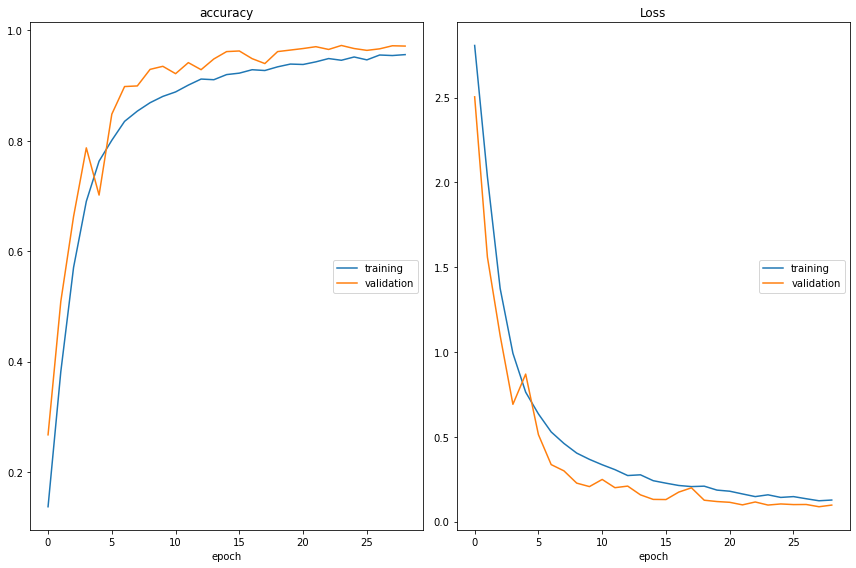

accuracy
	training         	 (min:    0.137, max:    0.956, cur:    0.956)
	validation       	 (min:    0.267, max:    0.973, cur:    0.972)
Loss
	training         	 (min:    0.123, max:    2.808, cur:    0.127)
	validation       	 (min:    0.087, max:    2.505, cur:    0.097)
4200/4200 [==============================] - 1s 251us/sample - loss: 0.1270 - accuracy: 0.9562 - val_loss: 0.0972 - val_accuracy: 0.9717


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
plt.close()

history = model.fit(train_data, 
                    train_classes, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(validation_data, validation_classes),
                    callbacks=[PlotLossesKeras(), early_stopping])

## Model with Adam

The second model is actually just the same, the difference is the optimizer using Adam

In [13]:
keras.backend.clear_session() # clear previous model (if cell is executed more than once)

### CNN MODEL DEFINITION ###
model1 = keras.models.Sequential()

model1.add(tf.keras.layers.Input(shape=(99, 20)))

model1.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.4))

model1.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu"))
model1.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.4))

model1.add(tf.keras.layers.Conv1D(128, kernel_size=5, activation="relu"))
model1.add(tf.keras.layers.GlobalMaxPooling1D())

model1.add(tf.keras.layers.Dense(256, activation="relu"))

model1.add(tf.keras.layers.Dense(128, activation="relu"))

model1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


# print model architecture
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 97, 32)            1952      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 95, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 29, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 64)            1

In [14]:
adam = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy() # use Sparse because classes are represented as integers not as one-hot encoding

model1.compile(optimizer=adam, loss=loss_fn, metrics=["accuracy"])

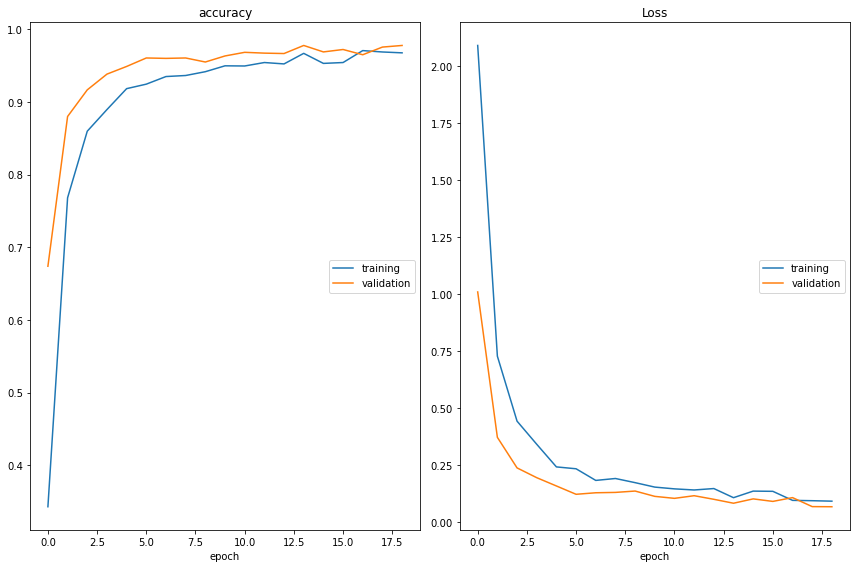

accuracy
	training         	 (min:    0.343, max:    0.971, cur:    0.968)
	validation       	 (min:    0.674, max:    0.978, cur:    0.978)
Loss
	training         	 (min:    0.092, max:    2.090, cur:    0.092)
	validation       	 (min:    0.067, max:    1.009, cur:    0.067)
4200/4200 [==============================] - 1s 264us/sample - loss: 0.0917 - accuracy: 0.9676 - val_loss: 0.0672 - val_accuracy: 0.9778


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
plt.close()

history = model1.fit(train_data, 
                    train_classes, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(validation_data, validation_classes),
                    callbacks=[PlotLossesKeras(), early_stopping])

As we can see, during the training, the losses decrease and the accuracy increases.
After training, we can save our model for later use if we want to.

In [17]:
# save model
model1.save("Saved_Model_arab.h5")

In [18]:
# load model
model1 = keras.models.load_model("Saved_Model_arab.h5")

To see the full correlation based on the predicted true positive on the test set, we can easily measured it by using confusion matrix using pyplot library. 

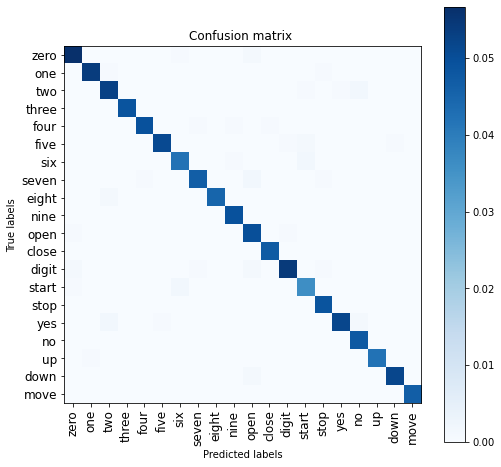

In [19]:
# plot confusion matrix
y = np.argmax(model.predict(validation_data), axis=1)
cm = confusion_matrix(validation_classes, y,  normalize="all")
%matplotlib inline
plt.close()
plt.figure(figsize = (8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(0, 20, 1), index2word, rotation=90)
plt.yticks(np.arange(0, 20, 1), index2word)
plt.tick_params(labelsize=12)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

down below is code to test our model by recording our voice and start predicting on it.

In [20]:
def extract_loudest_section(audio, length):
    audio = audio[:, 0].astype(np.float) # to avoid integer overflow when squaring
    audio_pw = audio**2 # power
    window = np.ones((length, ))
    conv = np.convolve(audio_pw, window, mode="valid")
    begin_index = conv.argmax()
    return audio[begin_index:begin_index+length]

Testing number 1 :
After running the cell, immidiately speak the word on the wordlist no longer than 2 seconds 

[1.5694743e-04 5.6650531e-02 3.8266106e-04 1.2018684e-07 1.9620946e-03
 9.8005512e-05 5.0074833e-09 4.4776494e-05 2.4336037e-05 2.9937719e-05
 6.7740613e-10 5.5511850e-07 6.9979966e-01 3.4362752e-10 1.3040138e-02
 1.4190403e-01 1.1915791e-06 8.5000806e-02 1.3613427e-06 9.0290309e-04]
candidates:
-----------------------------
1.)	digit	:	70.0%
2.)	yes	:	14.2%
3.)	up	:	8.5%
-----------------------------
feature computation time: 2.2 ms
CNN model prediction time: 66.4 ms
total time: 68.5 ms


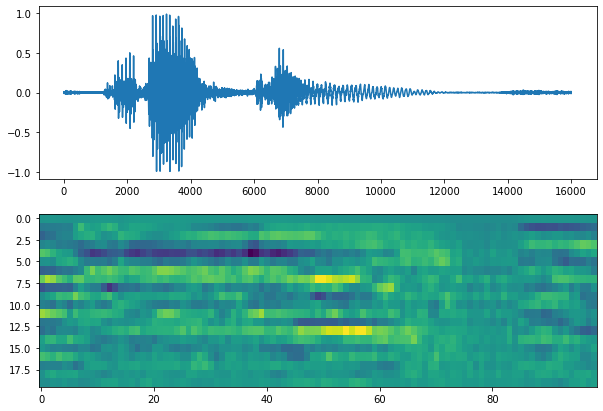

In [28]:
sd.default.samplerate = 16000
sd.default.channels = 1, 2 # mono record, stereo playback


recording = sd.rec(int(3*sd.default.samplerate), channels=1, samplerate=sd.default.samplerate, dtype=np.float, blocking=True)
recording = extract_loudest_section(recording, int(1*sd.default.samplerate)) # extract 1s snippet with highest energy (only necessary if recording is >3s long)
sd.play(recording, blocking=True)

t1 = timer()
recorded_feature = audio2feature(recording)
t2 = timer()
recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
prediction = model.predict(recorded_feature).reshape((20, ))
print(model.predict(recorded_feature).reshape((20, )))
t3 = timer()
# normalize prediction output to get "probabilities"
prediction /= prediction.sum()

# print the 3 candidates with highest probability
prediction_sorted_indices = prediction.argsort()
print("candidates:\n-----------------------------")
for k in range(3):
    i = int(prediction_sorted_indices[-1-k])
    print("%d.)\t%s\t:\t%2.1f%%" % (k+1, index2word[i], prediction[i]*100))
print("-----------------------------")
print("feature computation time: %2.1f ms" % ((t2-t1)*1e3))
print("CNN model prediction time: %2.1f ms" % ((t3-t2)*1e3))
print("total time: %2.1f ms" % ((t3-t1)*1e3))

plt.close()
plt.figure(1, figsize=(10, 7))
plt.subplot(211)
plt.plot(recording)
plt.subplot(212)
plt.imshow(recorded_feature.reshape(99, 20).T, aspect="auto")
plt.show()

Testing number 2 :
After running the cell, it will automatically predict voice in real time.

In [29]:
audio_buffer = np.zeros((5, 3200))
last_recognized_word = None
last_recognition_time = 0
recognition_timeout = 1.0

def audio_stream_callback(indata, frames, time, status):
    global audio_buffer
    global model
    global index2word
    global last_recognized_word
    global last_recognition_time
    audio_buffer = np.roll(audio_buffer, shift=-1, axis=0)
    audio_buffer[-1, :] = np.squeeze(indata)
    t1 = timer()
    recorded_feature = audio2feature(audio_buffer.flatten())
    recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
    t2 = timer()
    prediction = model.predict(recorded_feature).reshape((20, ))
    # normalize prediction output to get "probabilities"
    prediction /= prediction.sum()
    #print(prediction)
    best_candidate_index = prediction.argmax()
    best_candidate_probability = prediction[best_candidate_index]
    t3 = timer()
    if(best_candidate_probability > 0.7): # treshold
        word = index2word[best_candidate_index]
        if( (timer()-last_recognition_time)>recognition_timeout or word!=last_recognized_word ):
            last_recognition_time = timer()
            last_recognized_word = word
            clear_output(wait=True) # clear ouput as soon as new output is available to replace it
            print("%s\t:\t%2.1f%%" % (word, best_candidate_probability*100))
            print("-----------------------------")

In [31]:
# REALTIME KEYWORD RECOGNITION DEMO (60s long)
with sd.InputStream(samplerate=16000, blocksize=3200, device=None, channels=1, dtype="float32", callback=audio_stream_callback):
    sd.sleep(10*1000)

up	:	95.0%
-----------------------------


## TF Lite converter

In [27]:
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

In [28]:
word2index = [
    # core words
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "open",
    "close",
    "digit",
    "start",
    "stop",
    "yes",
    "no",
    "up",
    "down",
    "move",
]

In [29]:
textfile = open("label.txt", "w")
for element in word2index:
    textfile.write(element + "\n")
textfile.close()

In [ ]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_audio_inggris_contoh.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
AudioClassifierWriter = audio_classifier.MetadataWriter
_MODEL_PATH = "model_audio_inggris_contoh.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "label.txt"
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = 16000
# Expected number of channels of the input audio buffer. Note, Task library only
# support single channel so far.
_CHANNELS = 1
_SAVE_TO_PATH = "model_audio_inggris_metadata.tflite"

# Create the metadata writer.
writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "AudioClassifier",
  "description": "Identify the most prominent type in the audio clip from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
            "content_properties_type": "AudioProperties",
            "content_properties": {
              "sample_rate": 16000,
              "channels": 1
            }
          },
          "stats": {
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probability",
          "description": "Scores of the labels respectively.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              0.0
            ]
          },
          